In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
data = pd.read_csv('input/OnlineRetail.csv', encoding='latin1')

data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [50]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
data['Revenue'] = data['UnitPrice'] * data['Quantity']
revenue = data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
revenue

,InvoiceYearMonth,Revenue
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


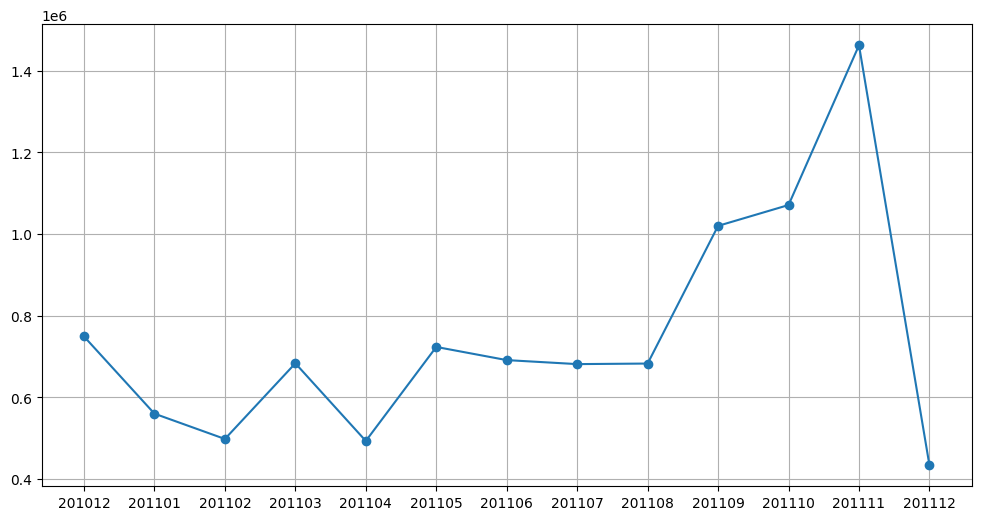

In [51]:
plt.figure(figsize=(12,6))
plt.plot(revenue['InvoiceYearMonth'].to_numpy(dtype=str), revenue['Revenue'].to_numpy(), marker='o')

plt.grid()
plt.show()

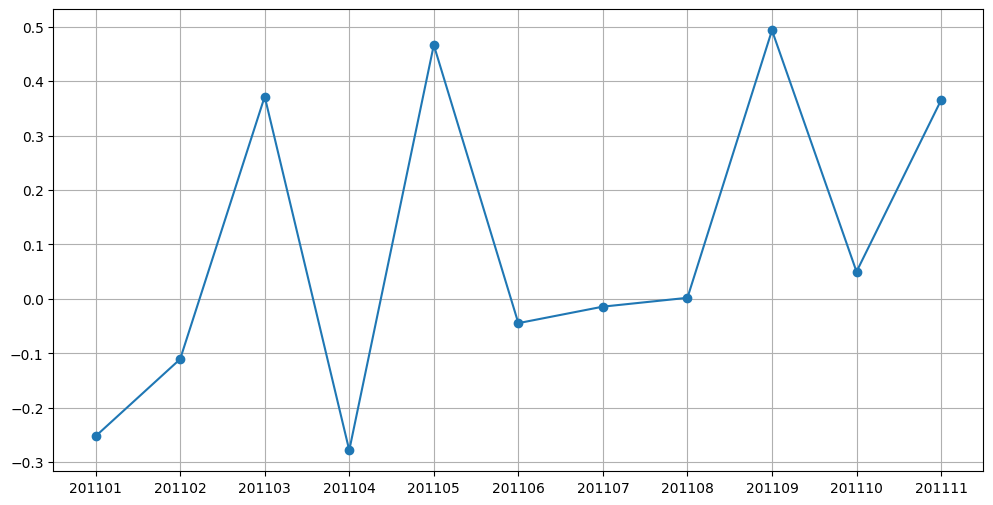

In [52]:
#using pct_change() function to see monthly percentage change
revenue['MonthlyGrowth'] = revenue['Revenue'].pct_change()
plt.figure(figsize=(12,6))
plt.plot(revenue.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'].to_numpy(dtype=str), 
        revenue.query("InvoiceYearMonth < 201112")['MonthlyGrowth'].to_numpy(), marker='o')

plt.grid()
plt.show()

In [53]:
data_uk = data.query("Country=='United Kingdom'").reset_index(drop=True)
monthly_active = data_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

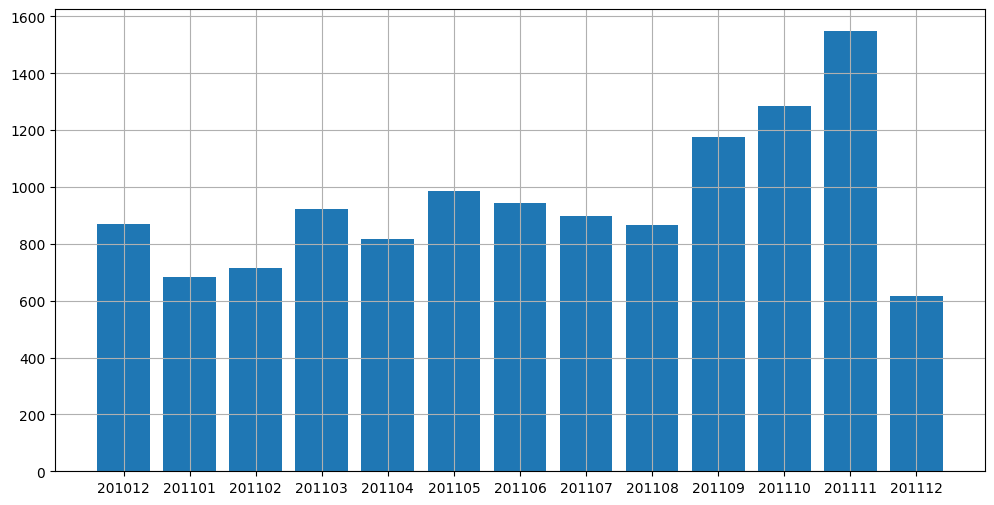

In [54]:
plt.figure(figsize=(12,6))
plt.bar(monthly_active['InvoiceYearMonth'].to_numpy(dtype=str), monthly_active['CustomerID'].to_numpy())

plt.grid()
plt.show()

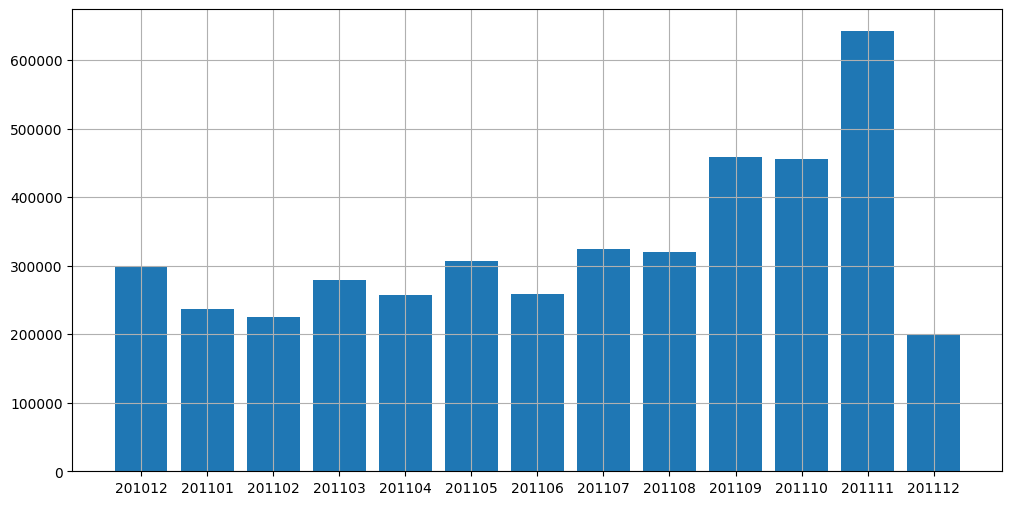

In [55]:
monthly_sales = data_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.bar(monthly_sales['InvoiceYearMonth'].to_numpy(dtype=str), monthly_sales['Quantity'].to_numpy())

plt.grid()
plt.show()

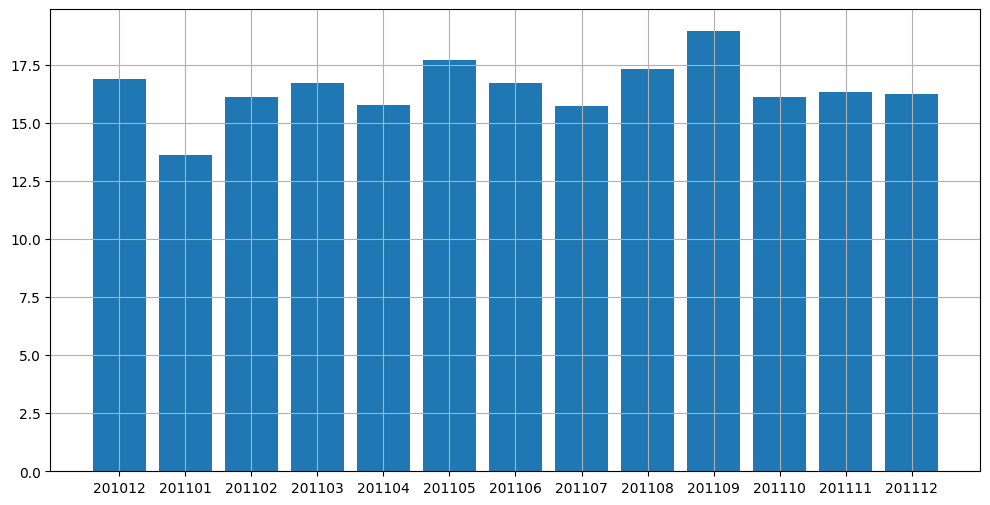

In [56]:
monthly_order_avr = data_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.bar(monthly_order_avr['InvoiceYearMonth'].to_numpy(dtype=str), monthly_order_avr['Revenue'].to_numpy())

plt.grid()
plt.show()

In [57]:
min_purchase = data_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
min_purchase.columns = ['CustomerID','MinPurchaseDate']
min_purchase['MinPurchaseYearMonth'] = min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
data_uk = pd.merge(data_uk, min_purchase, on='CustomerID')
# data_uk.head()
data_uk['UserType'] = 'New'
data_uk.loc[data_uk['InvoiceYearMonth']>data_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'
user_type_revenue = data_uk.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
user_type_revenue = user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")

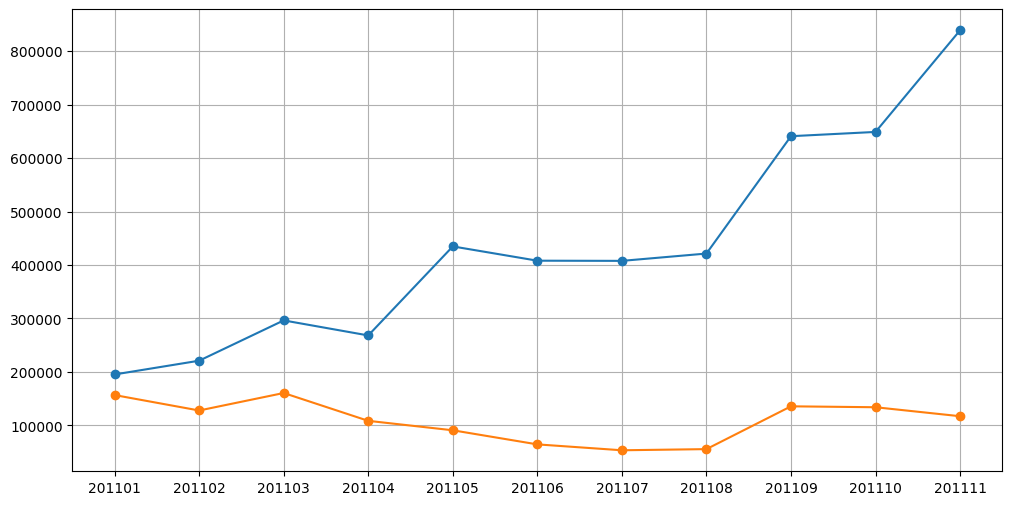

In [58]:
plt.figure(figsize=(12,6))
plt.plot(user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'].to_numpy(dtype=str), user_type_revenue.query("UserType == 'Existing'")['Revenue'].to_numpy(), marker='o')
plt.plot(user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'].to_numpy(dtype=str), user_type_revenue.query("UserType == 'New'")['Revenue'].to_numpy(), marker='o')

plt.grid()
plt.show()

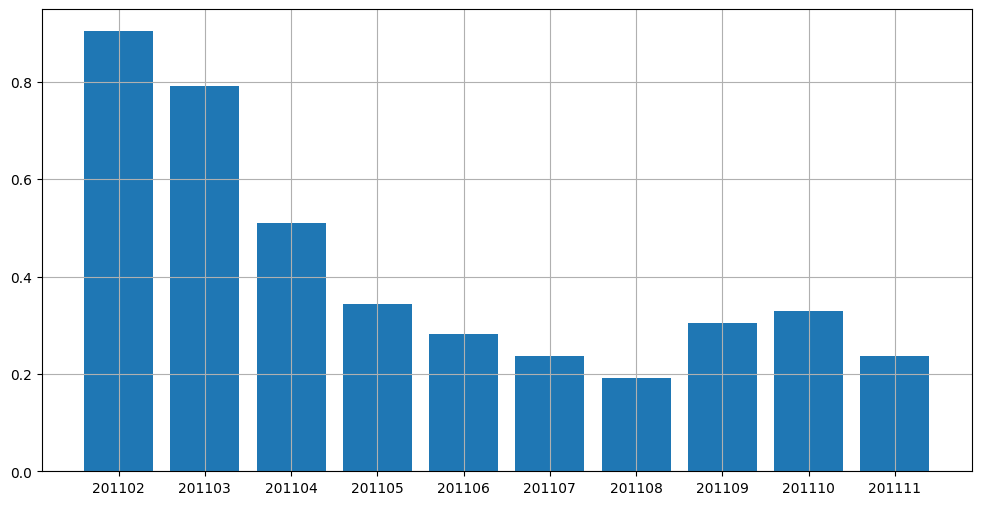

In [59]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
user_ratio = data_uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/data_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
user_ratio = user_ratio.reset_index()
user_ratio = user_ratio.dropna()
user_ratio
plt.figure(figsize=(12,6))
plt.bar(user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'].to_numpy(dtype=str),
        user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'].to_numpy())
        
plt.grid()
plt.show()

## Monthly Retention Rate

In [60]:
user_purchase = data_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()
retention = pd.crosstab(user_purchase['CustomerID'], user_purchase['InvoiceYearMonth']).reset_index()
retention.head()

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


In [61]:
#create an array of dictionary which keeps Retained & Total User count for each month
months = retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = retention[selected_month].sum()
    retention_data['RetainedUserCount'] = retention[(retention[selected_month]>0) & (retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
retention = pd.DataFrame(retention_array)
retention['RetentionRate'] = retention['RetainedUserCount']/retention['TotalUserCount']


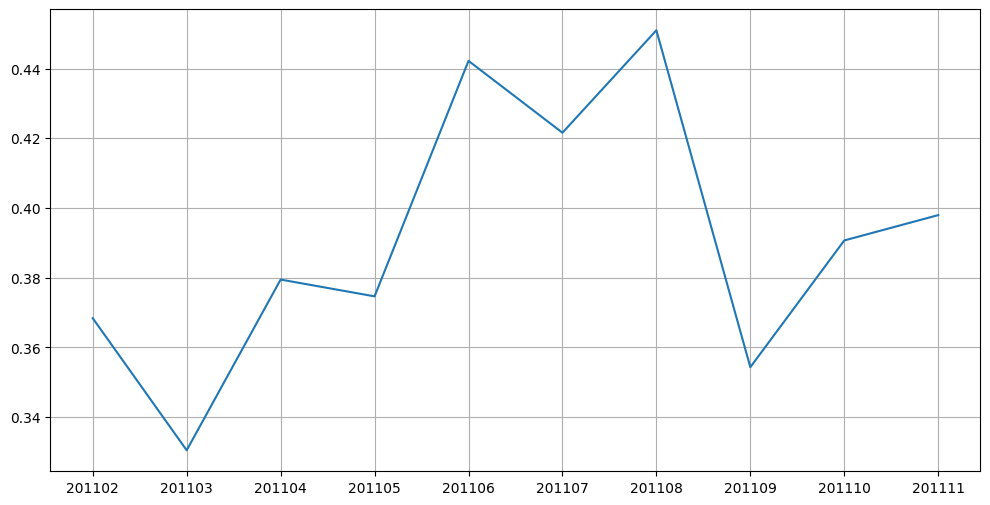

In [64]:
plt.figure(figsize=(12,6))
plt.plot(retention.query("InvoiceYearMonth<201112")['InvoiceYearMonth'].to_numpy(dtype=str),
        retention.query("InvoiceYearMonth<201112")['RetentionRate'].to_numpy())
        
plt.grid()
plt.show()